## Index:
* [Introduction](#intro)
* [Data Processing](#data-p)
* [Descriptive Analysis of Dataset Values](#descriptive-a)
* [Feature Extraction - Applying Time Window](#feature-e)

# Introduction <a class="anchor" id="intro"></a>
## Pre-Processing of the 2016-ANSAMO Dataset 

**Directory:**
    > `Subject_<nr>_ADL_<activity>.csv`
    > ...

**Types of Executed ADLs:**   
1) normal walking, 2) light jogging, 3) body bending, 4) hopping, 5) climbing stairs (up), 6) climbing stairs (down), 7) lying down and getting up from a bed, 8) sitting down (and up) on (from) a chair.

**Columns Units:**  
    After the header, every line in the files corresponds to a measurement captured by a particular mobility sensor of a determined node (mote or SensorTag).  
    The format of the lines, which is also explained in the file header, includes 7 numerical values separated by a semicolon:  
        -The time (in ms) since the experiment began.  
        -The number of the sample (for the same sensor and node).  
        -The three real numbers describing the measurements of the triaxial sensor (x-axis, y-axis and z-axis). The units are g, °/s or μT depending on whether the measurement was performed by an accelerometer, a gyroscope or a magnetometer, respectively.  
        -An integer (0, 1 or 2) describing the type of the sensor that originated the measurement (Accelerometer = 0 , Gyroscope = 1, Magnetometer = 2)  
        -An integer (from 0 to 4) informing about the sensing node (the correspondence between this numerical code and the Bluetooth MAC address and position of the motes is described in the file header).
        
## Desired Dataset Format

current header = TS(ms);SampleNr;X-Axis;Y-Axis;Z-Axis;SensorType;SensorID  
desired header = TS(ms); AccX; AccY; AccZ; MagnX; MagnY; MagnZ; GyroX; GyroY; GyroZ; SubjectID; Gender; Age; Position; Label; and other Feature Extraction Columns (mean, std, corr, etc...)

Pre-Processing Tasks:
    - clean headers information
    - divide the files by subject: "subject_01.csv"; "subject_02.csv"; ... with the desired header above.

In [ ]:
## Readme File ##
from IPython.display import IFrame
IFrame("./2016-ANSAMO-Readme.pdf", width=800, height=800)

In [31]:
def download_dataset(path):
    print("downloading dataset...")
    import sys
    sys.path.append('../../../')
    from ipynb.fs.full.Utils import download_from_google_drive
    download_from_google_drive('1fuMxj-dnMXEPHGhHwuQoNjBovO_v5Kdk', path);
    # https://drive.google.com/open?id=1fuMxj-dnMXEPHGhHwuQoNjBovO_v5Kdk
    print("saved at ", path)

In [17]:
def read_file(filepath):
    SUBJECTS = pd.DataFrame([
    {'id': 'Subject 01', 'age':'22', 'gender':'female', 'height':'167', 'weight': '63'},
    {'id': 'Subject 02', 'age':'27', 'gender':'male', 'height':'173', 'weight': '90'},
    {'id': 'Subject 03', 'age':'23', 'gender':'male', 'height':'179', 'weight': '68'}, 
    {'id': 'Subject 04', 'age':'24', 'gender':'male', 'height':'175', 'weight': '79'},
    {'id': 'Subject 05', 'age':'28', 'gender':'male', 'height':'195', 'weight': '81'},
    
    {'id': 'Subject 06', 'age':'22', 'gender':'female', 'height':'167', 'weight': '57'},
    {'id': 'Subject 07', 'age':'55', 'gender':'male', 'height':'170', 'weight': '83'},
    {'id': 'Subject 08', 'age':'19', 'gender':'male', 'height':'178', 'weight': '68'},
    {'id': 'Subject 09', 'age':'26', 'gender':'male', 'height':'176', 'weight': '73'},
    {'id': 'Subject 10', 'age':'51', 'gender':'female', 'height':'155', 'weight': '55'},
    
    {'id': 'Subject 11', 'age':'14', 'gender':'female', 'height':'159', 'weight': '50'},
    {'id': 'Subject 12', 'age':'22', 'gender':'female', 'height':'164', 'weight': '52'},
    {'id': 'Subject 13', 'age':'26', 'gender':'male', 'height':'179', 'weight': '67'},
    {'id': 'Subject 14', 'age':'21', 'gender':'male', 'height':'173', 'weight': '77'},
    {'id': 'Subject 15', 'age':'27', 'gender':'female', 'height':'166', 'weight': '66'},
    
    {'id': 'Subject 16', 'age':'24', 'gender':'male', 'height':'177', 'weight': '66'},
    {'id': 'Subject 17', 'age':'23', 'gender':'female', 'height':'163', 'weight': '93'},
])
    filename = ""
    try:
        filepath.index("/");
        array = filepath.split('/');
        filename = array[len(array) - 1]
    except:
        filename = filepath
    print(filename)
    ## filename = UMAFall_Subject_01_ADL_Bending_1_2016-06-13_20-25-34.csv
    array = filename.split('_')
    subjectID = array[1] + " " + array[2]
    label = array[4]
    experiment = array[4] + "_" + array[5]
    ### read csv
    train_dataRaw = pd.read_csv(filepath)
    ### remove first 31 lines
    train_data = train_dataRaw.iloc[31:]
    ### user characteristics
    user = SUBJECTS[SUBJECTS['id'].isin([subjectID])];
    age = user['age']
    gender = user['gender']
    height = user['height']
    weight = user['weight']

    return {"filecontent": train_data, 
             'experiment': experiment, 
             'label': label, 
             'subjectID': subjectID,
             'filename': filename, 
             'gender': gender.values[0], 
             'age': age.values[0], 
             'height': height.values[0], 
             'weight': weight.values[0]};
   

###output = read_file("../../../datasets/ANSAMO-2016/UMA_ADL_FALL_Dataset/UMAFall_Subject_01_ADL_Bending_1_2016-06-13_20-25-34.csv");

In [18]:
def split_positions_and_signals(filecontent):
    ''' filecontent = pd.DataFrame '''

    ##  Sensor_ID	 Position	 Device Model                                   
    #0	 RIGHTPOCKET	 lge-LG-H815-5.1                                
    #1	 CHEST	 SensorTag
    #2	 WAIST	 SensorTag
    #3	 WRIST	 SensorTag                                            
    #4	 ANKLE	 SensorTag                                                                                                            
    RIGHTPOCKET = '0'
    CHEST = '1'
    WAIST = '2'
    WRIST = '3'
    ANKLE = '4'
    #% Sensor_Type:                                                                     
    #% Accelerometer = 0                                                                
    #% Gyroscope = 1                                                                    
    #% Magnetometer = 2 
    ACCE = '0'
    GYRO = '1'
    MAGN = '2'
    
    ### divide line into several columns
    header_tmp = {'ts(ms)': [], 'SampleNr': [], 'X-Axis': [], 'Y-Axis': [], 'Z-Axis': [], 'SensorType': [] , 'SensorID': []}
    values = pd.DataFrame(data=header_tmp)
    i = 0
    for index, row in filecontent.iterrows():
            line = row[0]
            array = line.split(';')
            if i > 0: values = values.append(pd.DataFrame({'ts(ms)': [array[0]], 'SampleNr': [array[1]], 'X-Axis': [array[2]], 'Y-Axis': [array[3]], 'Z-Axis': [array[4]], 'SensorType': [array[5]] , 'SensorID': [array[6]]}))
            i+=1;
    ### sorting per sensorid, sensortype, and ts
    train_data_processed_ordered = values.sort_values(['SensorID', 'SensorType', 'ts(ms)']);
    ### start splitting into positions and signals
    # divide signals per position
    train_data_pocket = train_data_processed_ordered[train_data_processed_ordered['SensorID'].isin([RIGHTPOCKET])];
    train_data_chest = train_data_processed_ordered[train_data_processed_ordered['SensorID'].isin([CHEST])];
    train_data_waist = train_data_processed_ordered[train_data_processed_ordered['SensorID'].isin([WAIST])];
    train_data_wrist = train_data_processed_ordered[train_data_processed_ordered['SensorID'].isin([WRIST])];
    train_data_ankle = train_data_processed_ordered[train_data_processed_ordered['SensorID'].isin([ANKLE])];
    # pocket 
    pocket_acc = train_data_pocket[train_data_pocket['SensorType'].isin([ACCE])];
    pocket_gyro = train_data_pocket[train_data_pocket['SensorType'].isin([GYRO])];
    pocket_magn = train_data_pocket[train_data_pocket['SensorType'].isin([MAGN])];
    # wrist
    wrist_acc = train_data_wrist[train_data_wrist['SensorType'].isin([ACCE])];
    wrist_gyro = train_data_wrist[train_data_wrist['SensorType'].isin([GYRO])];
    wrist_magn = train_data_wrist[train_data_wrist['SensorType'].isin([MAGN])];
    # ankle
    ankle_acc = train_data_ankle[train_data_ankle['SensorType'].isin([ACCE])];
    ankle_gyro = train_data_ankle[train_data_ankle['SensorType'].isin([GYRO])];
    ankle_magn = train_data_ankle[train_data_ankle['SensorType'].isin([MAGN])];
    # waist
    waist_acc = train_data_waist[train_data_waist['SensorType'].isin([ACCE])];
    waist_gyro = train_data_waist[train_data_waist['SensorType'].isin([GYRO])];
    waist_magn = train_data_waist[train_data_waist['SensorType'].isin([MAGN])];
    # chest
    chest_acc = train_data_chest[train_data_chest['SensorType'].isin([ACCE])];
    chest_gyro = train_data_chest[train_data_chest['SensorType'].isin([GYRO])];
    chest_magn = train_data_chest[train_data_chest['SensorType'].isin([MAGN])];
    
    return {'pocket_acc':pocket_acc,
           'pocket_gyro':pocket_gyro,
           'pocket_magn':pocket_magn,
           
           'wrist_acc':wrist_acc,
           'wrist_gyro':wrist_gyro,
           'wrist_magn':wrist_magn,
           
           'ankle_acc':ankle_acc,
           'ankle_gyro':ankle_gyro,
           'ankle_magn':ankle_magn,
           
           'waist_acc':waist_acc,
           'waist_gyro':waist_gyro,
           'waist_magn':waist_magn,
           
           'chest_acc':chest_acc,
           'chest_gyro':chest_gyro,
           'chest_magn':chest_magn,
           
            'train_data_pocket':train_data_pocket,
            'train_data_chest':train_data_chest,
            'train_data_waist':train_data_waist,
            'train_data_wrist':train_data_wrist,
            'train_data_ankle':train_data_ankle,
           };

##filecontent = pd.DataFrame(output['filecontent']);
##values = split_positions_and_signals(filecontent);

In [19]:
def join_all_signals_types(signals, info):
    ''' Receives the argument: 
    sigmals = pd.DataFrame([
    {   'value': pocket_acc, 'signalType': 'acc'},  {'value': pocket_gyro, 'signalType': 'gyro'}, ... 
    info = pd.DataFrame([{
        'userGender': 'male',
        'userAge': '55',
        'userID':'sdasd'
        'position': 2
        'filename': 'asda.csv',
        'experiment': 'Bending_1',
        'label': 'Bending'}]) 
    '''
    userAge = info['userAge']
    userGender = info['userGender']
    userID = info['userID']
    label = info['label']
    filename = info['filename']
    experiment = info['experiment']
    
    header = [ 'ts(ms)', 'accX', 'accY', 'accZ',
              'magX', 'magY', 'magZ',
              'gyrX', 'gyrY', 'gyrZ',
              'userGender', 'userAge', 'userID',
              'position', 
              'label',
              'filename',
              'experiment' ];
    all_values = pd.DataFrame(columns=header);
    
    for indexR, lineR in signals.iterrows():
        array = lineR['value'];
        signalType = lineR['signalType'];
        position = lineR['position'];
        
        for index, line in array.iterrows():
            row = all_values[all_values['ts(ms)'] == line['ts(ms)']];
            ts_tmp = [line['ts(ms)']];
            
            if signalType is "acc": 
                 acc_values_tmp = [ [line['X-Axis']] ,  [line['Y-Axis']],  [line['Z-Axis']]];
                 magn_values_tmp = [ [-1] ,  [-1],  [-1]];
                 gyro_values_tmp = [ [-1] ,  [-1],  [-1]]; 
            elif signalType is "magn":
                 acc_values_tmp = [ [-1] ,  [-1],  [-1]]; 
                 magn_values_tmp = [ [line['X-Axis']] ,  [line['Y-Axis']],  [line['Z-Axis']]];
                 gyro_values_tmp = [ [-1] ,  [-1],  [-1]]; 
            else:
                acc_values_tmp = [ [-1] ,  [-1],  [-1]];    
                magn_values_tmp = [ [-1] ,  [-1],  [-1]];
                gyro_values_tmp = [ [line['X-Axis']] ,  [line['Y-Axis']],  [line['Z-Axis']]];      

            if row.size == 0:
                all_values = all_values.append(pd.DataFrame({'ts(ms)': ts_tmp, 
                                    'accX':acc_values_tmp[0],
                                    'accY':acc_values_tmp[1],
                                    'accZ': acc_values_tmp[2], 
                                    'magX':magn_values_tmp[0],
                                    'magY':magn_values_tmp[1], 
                                    'magZ': magn_values_tmp[2], 
                                    'gyrX':gyro_values_tmp[0],
                                    'gyrY': gyro_values_tmp[1],
                                    'gyrZ': gyro_values_tmp[2], 
                                    'userGender': userGender, 
                                    'userAge': userAge, 
                                    'userID': userID,
                                    'position': position, 
                                    'label':label.values,
                                    'filename':filename,
                                    'experiment': experiment}))
            else:
                row.at[index, 'accX'] = acc_values_tmp[0];
                row.at[index, 'accY'] = acc_values_tmp[1];
                row.at[index, 'accZ'] = acc_values_tmp[2];
                
                row.at[index, 'gyrX'] = gyro_values_tmp[0];
                row.at[index, 'gyrY'] = gyro_values_tmp[1];
                row.at[index, 'gyrZ'] = gyro_values_tmp[2];
                
                row.at[index, 'magZ'] = magn_values_tmp[2];
                row.at[index, 'magZ'] = magn_values_tmp[2];
                row.at[index, 'magZ'] = magn_values_tmp[2];
                
    return all_values;

###
###signals = pd.DataFrame([{'value': wrist_gyro, 'signalType': 'gyro'}])
###all_values = join_all_signals_types(signals)
###print("len of all values:", len(all_values));

In [20]:
def process_file(filePath):
    ### read file
    output = read_file(filePath)
    filecontent = pd.DataFrame(output['filecontent']);
    ###
    experiment = output['experiment'];
    label = output['label'];
    subjectID = output['subjectID'];
    filename = output['filename'];
    gender = output['gender'];
    age = output['age'];
    height = output['height'];
    weight = output['weight'];
    info = pd.DataFrame([{
        'userGender': gender,
        'userAge': age,
        'userID': subjectID,
        'filename': filename,
        'experiment': experiment,
        'label': label
    }])
    ### split into positions and signal type
    values = split_positions_and_signals(filecontent);
    ### 
    pocket_acc = values['pocket_acc']
    pocket_gyro = values['pocket_gyro']
    pocket_magn = values['pocket_magn']

    wrist_acc = values['wrist_acc']
    wrist_gyro = values['wrist_gyro']
    wrist_magn = values['wrist_magn']

    ankle_acc = values['ankle_acc']
    ankle_gyro = values['ankle_gyro']
    ankle_magn = values['ankle_magn']

    waist_acc = values['waist_acc']
    waist_gyro = values['waist_gyro']
    waist_magn = values['waist_magn']

    chest_acc = values['chest_acc']
    chest_gyro = values['chest_gyro']
    chest_magn = values['chest_magn']

    signalsPocket = pd.DataFrame(
        [
         {'value': pocket_acc, 'signalType': 'acc', 'position': 'pocket'},
         {'value': pocket_gyro, 'signalType': 'gyro', 'position': 'pocket'},
         {'value': pocket_magn, 'signalType': 'magn', 'position': 'pocket'},
        ]);

    signalsAnkle = pd.DataFrame(
        [
        {'value': ankle_acc, 'signalType': 'acc', 'position': 'ankle'},
        {'value': ankle_gyro, 'signalType': 'gyro', 'position': 'ankle'},
        {'value': ankle_magn, 'signalType': 'magn', 'position': 'ankle'},
        ]);

    signalsWrist = pd.DataFrame(
        [
         {'value': wrist_acc, 'signalType': 'acc', 'position': 'wrist'},
         {'value': wrist_gyro, 'signalType': 'gyro', 'position': 'wrist'},
         {'value': wrist_magn, 'signalType': 'magn', 'position': 'wrist'},
        ]);

    signalsWaist = pd.DataFrame(
        [
        {'value': waist_acc, 'signalType': 'acc', 'position': 'waist'},
        {'value': waist_gyro, 'signalType': 'gyro', 'position': 'waist'},
        {'value': waist_magn, 'signalType': 'magn', 'position': 'waist'},
        ]);

    signalsChest = pd.DataFrame(
        [
        {'value': chest_acc, 'signalType': 'acc', 'position': 'chest'},
        {'value': chest_gyro, 'signalType': 'gyro', 'position': 'chest'},
        {'value': chest_magn, 'signalType': 'magn', 'position': 'chest'},
        ]);
    ### join all values
    all_values = join_all_signals_types(signalsPocket, info);
    all_values = all_values.append(join_all_signals_types(signalsAnkle, info))
    all_values = all_values.append(join_all_signals_types(signalsWrist, info))
    all_values = all_values.append(join_all_signals_types(signalsWaist, info))
    all_values = all_values.append(join_all_signals_types(signalsChest, info))
    
    return all_values;

In [21]:
from ipynb.fs.full.Utils import download_from_google_drive
help(download_from_google_drive)

Help on function download_from_google_drive in module ipynb.fs.full.Utils:

download_from_google_drive(id, destPath)
    This function downloads Google Drive Shared Files By Passing Its Sharing Link And The Desired Destination Path



In [36]:
import os
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sys, subprocess
dependencies = ['ipynb', 'googledrivedownloader']
subprocess.call([sys.executable, '-m', 'pip', 'install'] + dependencies)

download_dataset("./Dataset/ansamo.zip");
print("Please Unzip File... Press Enter When Done.");
yourvar = input('Choose a number: ')
base_path = './Dataset/ansamo/UMA_ADL_FALL_Dataset/'
files = os.listdir(base_path)
total = pd.DataFrame();
for file in files:
    if '.csv' in file:
        print("processing file: " + base_path + "/" + file + " wait...")
        filePath = base_path+"/"+file;
        values = process_file(filePath);
        total = total.append(values)

total.to_csv("all_values.csv", sep=',')
print("done!")   

downloading dataset...
The File Already Exists. Please Change The Path Destination.
saved at  ./Dataset/ansamo.zip
Please Unzip File... Press Enter When Done.
Choose a number: 
processing file: ./Dataset/ansamo/UMA_ADL_FALL_Dataset//UMAFall_Subject_01_ADL_Bending_1_2016-06-13_20-25-34.csv wait...
UMAFall_Subject_01_ADL_Bending_1_2016-06-13_20-25-34.csv
processing file: ./Dataset/ansamo/UMA_ADL_FALL_Dataset//UMAFall_Subject_01_ADL_Bending_2_2016-06-13_20-26-15.csv wait...
UMAFall_Subject_01_ADL_Bending_2_2016-06-13_20-26-15.csv
processing file: ./Dataset/ansamo/UMA_ADL_FALL_Dataset//UMAFall_Subject_01_ADL_Bending_3_2016-06-13_20-26-59.csv wait...
UMAFall_Subject_01_ADL_Bending_3_2016-06-13_20-26-59.csv
processing file: ./Dataset/ansamo/UMA_ADL_FALL_Dataset//UMAFall_Subject_01_ADL_forwardFall_1_2016-06-13_20-43-52.csv wait...
UMAFall_Subject_01_ADL_forwardFall_1_2016-06-13_20-43-52.csv
processing file: ./Dataset/ansamo/UMA_ADL_FALL_Dataset//UMAFall_Subject_01_ADL_Hopping_1_2016-06-13_20-

processing file: ./Dataset/ansamo/UMA_ADL_FALL_Dataset//UMAFall_Subject_02_ADL_Hopping_3_2016-06-13_13-02-19.csv wait...
UMAFall_Subject_02_ADL_Hopping_3_2016-06-13_13-02-19.csv
processing file: ./Dataset/ansamo/UMA_ADL_FALL_Dataset//UMAFall_Subject_02_ADL_Jogging_1_2016-06-13_13-07-16.csv wait...
UMAFall_Subject_02_ADL_Jogging_1_2016-06-13_13-07-16.csv
processing file: ./Dataset/ansamo/UMA_ADL_FALL_Dataset//UMAFall_Subject_02_ADL_Jogging_2_2016-06-13_13-07-58.csv wait...
UMAFall_Subject_02_ADL_Jogging_2_2016-06-13_13-07-58.csv
processing file: ./Dataset/ansamo/UMA_ADL_FALL_Dataset//UMAFall_Subject_02_ADL_Jogging_3_2016-06-13_13-08-41.csv wait...
UMAFall_Subject_02_ADL_Jogging_3_2016-06-13_13-08-41.csv
processing file: ./Dataset/ansamo/UMA_ADL_FALL_Dataset//UMAFall_Subject_02_ADL_LyingDown_OnABed_1_2016-06-13_13-10-22.csv wait...
UMAFall_Subject_02_ADL_LyingDown_OnABed_1_2016-06-13_13-10-22.csv
processing file: ./Dataset/ansamo/UMA_ADL_FALL_Dataset//UMAFall_Subject_02_ADL_LyingDown_OnA

KeyboardInterrupt: 

# Data Processing <a class="anchor" id="data-p"></a>
## Joining All Values Of Each Signal Into Same Lines

In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
base_path = "./Dataset/ansamo/";

In [43]:
###
### Read CSV File
###
all_values = pd.read_csv(base_path + "all_values.csv");
all_values.dtypes

Unnamed: 0      int64
accX          float64
accY          float64
accZ          float64
experiment     object
filename       object
gyrX          float64
gyrY          float64
gyrZ          float64
label          object
magX          float64
magY          float64
magZ          float64
position       object
ts(ms)          int64
userAge         int64
userGender     object
userID         object
dtype: object

In [41]:
###
###
###
print("nr of instances:", len(all_values))
list_of_users = list(set(all_values['userID']))
print("nr of users: ", len(list_of_users))
ageDistribution = list(set(all_values['userAge']))
print("age distribution", ageDistribution)
labels = list(set(all_values['label']))
print("labels:", labels)
print("\nusers :", list(set(all_values['userID'])))

nr of instances: 2843028
nr of users:  17
age distribution [14, 19, 51, 55, 22, 23, 24, 21, 26, 27, 28]
labels: ['lateralFall', 'GoDownstairs', 'forwardFall', 'Hopping', 'Sitting', 'Walking', 'Jogging', 'GoUpstairs', 'backwardFall', 'Bending', 'LyingDown']

users : ['Subject 15', 'Subject 06', 'Subject 08', 'Subject 02', 'Subject 01', 'Subject 14', 'Subject 09', 'Subject 07', 'Subject 12', 'Subject 03', 'Subject 17', 'Subject 04', 'Subject 10', 'Subject 16', 'Subject 13', 'Subject 05', 'Subject 11']


In [44]:
###
### Each User With A Separate File
###
users = list(set(all_values['userID']));

for line in users:
    subject_index = all_values[all_values['userID'].isin([line])]
    print(line, " " , len(subject_index))
    subject_index.to_csv(base_path + "_" + line + ".csv");

Subject 15   128784
Subject 06   61969
Subject 08   85714
Subject 02   183943
Subject 01   236210
Subject 14   67276
Subject 09   221925
Subject 07   93653
Subject 12   167738
Subject 03   227716
Subject 17   150759
Subject 04   235954
Subject 10   90067
Subject 16   555730
Subject 13   117225
Subject 05   129682
Subject 11   88683


In [45]:
from math import fabs
def sliding_window(values, time_interval_ms, time_interval_unc):
    ''' ( values, time_interval_ms, time_interval_unc)
    '''
    old_ts = 0;
    old_acc = [-1,-1,-1];
    old_gyr = [-1,-1,-1];
    old_mag = [-1,-1,-1];
    header = [ 'Its(ms)', 'Fts(ms)',
                  'accX', 'accY', 'accZ',
                  'magX', 'magY', 'magZ',
                  'gyrX', 'gyrY', 'gyrZ',
                  'userGender', 'userAge', 'userID',
                  'position', 
                  'label',
                  'filename',
                  'experiment' ];
    final_values = pd.DataFrame(columns=header);
    values = values.sort_values(['ts(ms)']);

    for index, line in values.iterrows():
        ts = line['ts(ms)']
        acc = [ line['accX'], line['accY'],  line['accZ']]
        gyr = [ line['gyrX'], line['gyrY'],  line['gyrZ']]
        mag = [ line['magX'], line['magY'],  line['magZ']]
        if acc[0] != -1:
            old_acc = acc;
        if gyr[0] != -1:
            old_gyr = gyr;
        if mag[0] != -1:
            old_mag = mag;    
        diff = ts - old_ts;
        
        if diff < 0:
            raise ValueError('The List Is Not Sorted By Time!!!') 

        if diff == time_interval_ms or fabs(diff - time_interval_ms) <= time_interval_unc:
            final_values = final_values.append(pd.DataFrame([{
                 'Its(ms)': old_ts, 'Fts(ms)': ts,
                  'accX': old_acc[0], 'accY': old_acc[1], 'accZ': old_acc[2],
                  'magX': old_mag[0], 'magY': old_mag[1], 'magZ': old_mag[2],
                  'gyrX': old_gyr[0], 'gyrY': old_gyr[1], 'gyrZ': old_gyr[2],
                  'userGender': line['userGender'], 'userAge': line['userAge'], 'userID': line['userID'],
                  'position': line['position'], 
                  'label': line['label'],
                  'filename': line['filename'],
                  'experiment': line['experiment']}]));
            old_ts = ts;
        elif diff > time_interval_ms:
            old_ts = ts;
    return final_values;

In [46]:
time_interval_ms = 50;
time_interval_unc = 10;
final_array = pd.DataFrame()
# users
users = list(set(all_values['userID']));
for line in users:
    subject = all_values[all_values['userID'].isin([line])]
    print(line, ", ", len(subject))
    #experiments
    experiments = list(set(subject['experiment']))
    for lineExp in experiments:
        subject_exp = subject[subject['experiment'].isin([lineExp])]        
        #positions
        positions = list(set(subject_exp['position']))
        for linePos in positions:
            subject_exp_pos = subject_exp[subject_exp['position'].isin([linePos])]
            final_array = final_array.append(sliding_window(subject_exp_pos, time_interval_ms, time_interval_unc));      
    print(len(final_array));
    
final_array.to_csv("all_users_50ms.csv");

Subject 15 ,  128784
24517
Subject 06 ,  61969
37345
Subject 08 ,  85714
49534
Subject 02 ,  183943
86232
Subject 01 ,  236210
131923
Subject 14 ,  67276
145530
Subject 09 ,  221925
191602
Subject 07 ,  93653
204519
Subject 12 ,  167738
230380
Subject 03 ,  227716
275029
Subject 17 ,  150759
296652
Subject 04 ,  235954
340987
Subject 10 ,  90067
353839
Subject 16 ,  555730
442063
Subject 13 ,  117225
465782
Subject 05 ,  129682
490707
Subject 11 ,  88683
503779


## Data Processing
### Filtering Values - Removing pocket signals, falling labels

In [7]:
all_values = pd.read_csv("./Dataset/ansamo/t1-2_all_users_50ms.csv");

In [8]:
# Remove pocket signals
positions = list(set(all_values['position']))
print(positions)
print("all signals: ", len(all_values));
all_values = all_values[~all_values['position'].isin(['pocket'])];
print("non-pocket signals: ", len(all_values));

['waist', 'pocket', 'ankle', 'chest', 'wrist']
all signals:  503779
non-pocket signals:  361149


In [9]:
# Remove falling labels except Sitting, GoUpstairs, Bending, Walking, Jogging, Hoping, GoDownstairs
labels = list(set(all_values['label']))
print(labels)
desired_labels = ['Sitting', 'Bending', 'Walking', 'Jogging', 'Hopping', 
                  'GoUpstairs', 'GoDownstairs']
all_values_2 = all_values[all_values['label'].isin(desired_labels)];
print(len(all_values))
print(len(all_values_2))

['LyingDown', 'Hopping', 'Walking', 'lateralFall', 'forwardFall', 'Bending', 'Sitting', 'GoDownstairs', 'GoUpstairs', 'backwardFall', 'Jogging']
361149
175375


In [10]:
positions = list(set(all_values_2['position']))
print(positions)
labels = list(set(all_values_2['label']))
print(labels)
age = list(set(all_values_2['userAge']))
print(age)

old = all_values_2[all_values_2['userAge'].isin(['55'])];
labels = list(set(old['label']))
print(labels)

old = all_values_2[all_values_2['userAge'].isin(['51'])];
labels = list(set(old['label']))
print(labels)

['wrist', 'ankle', 'chest', 'waist']
['Hopping', 'Walking', 'Bending', 'Sitting', 'GoDownstairs', 'GoUpstairs', 'Jogging']
[14, 19, 23, 21, 22, 55, 24, 51, 26, 27, 28]
['Hopping', 'Walking', 'Bending', 'Sitting', 'GoDownstairs', 'GoUpstairs']
['Hopping', 'Walking', 'Bending', 'Sitting', 'GoDownstairs', 'GoUpstairs']


,Unnamed: 0,Fts(ms),Its(ms),accX,accY,accZ,experiment,filename,gyrX,gyrY,gyrZ,label,magX,magY,magZ,position,userAge,userGender,userID


In [12]:
all_values_2.to_csv("./Dataset/ansamo/t1-3_all_values_50ms.csv");

## Descriptive Analysis <a class="anchor" id="descriptive-a"></a>
#### Descriptive Analysis of Signals In Each Experiment

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
all_values = pd.read_csv("./Dataset/ansamo/t1-3_all_values_50ms.csv");

In [2]:
all_values.describe()

,Unnamed: 0,Unnamed: 0.1,Fts(ms),Its(ms),accX,accY,accZ,gyrX,gyrY,gyrZ,magX,magY,magZ,userAge
count,175375.000000,175375.0,175375.000000,175375.00000,175375.000000,175375.000000,175375.000000,175375.000000,175375.000000,175375.000000,175375.000000,175375.000000,175375.000000,175375.000000
mean,252762.787883,0.0,7505.649488,7457.47147,0.600532,-0.055701,0.075002,-2.126005,-0.171710,-0.794811,-11.509510,-7.031505,-28.754855,26.158227
std,147975.319402,0.0,4208.938001,4209.05653,0.935383,0.462584,0.525032,65.190146,69.084292,51.765024,65.091665,58.132460,101.711870,8.727373
min,1368.000000,0.0,50.000000,0.00000,-6.892090,-8.000000,-7.937256,-256.898438,-257.000000,-256.828125,-187.500000,-192.000000,-234.666672,14.000000
25%,128985.500000,0.0,3850.000000,3801.00000,0.125977,-0.184570,-0.107178,-14.554688,-13.500000,-8.398438,-59.500000,-19.333334,-107.333336,22.000000
50%,243539.000000,0.0,7472.000000,7424.00000,0.918945,-0.050049,0.089600,-1.718750,-0.281250,-1.148438,-12.500000,-1.500000,-26.166666,24.000000
75%,380984.500000,0.0,11065.000000,11017.00000,1.007324,0.068359,0.297363,10.558594,10.500000,7.101562,38.166668,33.333332,50.833332,27.000000
max,503778.000000,0.0,15036.000000,14982.00000,8.000000,7.937256,8.000000,254.992188,254.812500,254.898438,146.833328,98.333336,218.500000,55.000000


In [3]:
def create_figure(time , sensorX_y, sensorY_y, sensorZ_y, 
                 fig_title,
                 label_x,
                 label_y,
                destPath):
    
    import pylab as plt
    import numpy as np
    fig, axs=plt.subplots(1,3)
    fig.set_size_inches(30, 5, forward=True)
    fig.set_dpi(200)
    ax=axs.ravel()
    
    ax[0].plot(time, sensorX_y)
    ax[1].plot(time, sensorY_y)
    ax[2].plot(time, sensorZ_y)
    
    ax[0].set_title("X-AXIS")
    ax[0].set_ylabel(label_y)
    ax[0].set_xlabel(label_x)

    ax[1].set_title("Y-AXIS")
    ax[1].set_ylabel(label_y)
    ax[1].set_xlabel(label_x)
    
    ax[2].set_title("Z-AXIS")
    ax[2].set_ylabel(label_y)
    ax[2].set_xlabel(label_x)

    fig.suptitle(fig_title, fontsize=20)
    fig.savefig(destPath)
    plt.close(fig);
    plt.close()

In [4]:
# Descriptive Analysis of Each Signal During Each Experiment
users = list(set(all_values['userID']));
users.sort()
# users
for line in users:
    subject = all_values[all_values['userID'].isin([line])]
    print(line, ", ", len(subject))
    #experiments
    experiments = list(set(subject['experiment']))
    for lineExp in experiments:
        subject_exp = subject[subject['experiment'].isin([lineExp])]        
        #positions
        positions = list(set(subject_exp['position']))
        for linePos in positions:
            subject_exp_pos = subject_exp[subject_exp['position'].isin([linePos])]
            subject01_exp_pos_sor = subject_exp_pos.sort_values(['Fts(ms)'])
            time = subject01_exp_pos_sor['Fts(ms)'].values
            # acc
            sensorX_y = subject01_exp_pos_sor['accX'].values;
            sensorY_y = subject01_exp_pos_sor['accY'].values;
            sensorZ_y = subject01_exp_pos_sor['accZ'].values;
            fig_title = "ACC_" + line + "_" + lineExp + "_" + linePos
            label_y = "G"
            label_x = "TS(MS)"
            destPath = "./Dataset/Signals Analysis/" + fig_title + ".jpg"
            create_figure(time,
                          sensorX_y, sensorY_y, sensorZ_y, 
                          fig_title, label_x, label_y, destPath);
            # mag
            sensorX_y = subject01_exp_pos_sor['magX'].values;
            sensorY_y = subject01_exp_pos_sor['magY'].values;
            sensorZ_y = subject01_exp_pos_sor['magZ'].values;
            fig_title = "MAG_" + line + "_" + lineExp + "_" + linePos
            label_y = "uT"
            label_x = "TS(MS)"
            destPath = "./Dataset/Signals Analysis/" + fig_title + ".jpg"
            create_figure(time,
                          sensorX_y, sensorY_y, sensorZ_y, 
                          fig_title, label_x, label_y, destPath);
            # gyr
            sensorX_y = subject01_exp_pos_sor['gyrX'].values;
            sensorY_y = subject01_exp_pos_sor['gyrY'].values;
            sensorZ_y = subject01_exp_pos_sor['gyrZ'].values;
            fig_title = "GYR_" + line + "_" + lineExp + "_" + linePos
            label_y = "degrees/second"
            label_x = "TS(MS)"
            destPath = "./Dataset/Signals Analysis/" + fig_title + ".jpg"
            create_figure(time,
                          sensorX_y, sensorY_y, sensorZ_y, 
                          fig_title, label_x, label_y, destPath);

['Subject 01', 'Subject 02', 'Subject 03', 'Subject 04', 'Subject 05', 'Subject 06', 'Subject 07', 'Subject 08', 'Subject 09', 'Subject 10', 'Subject 11', 'Subject 12', 'Subject 13', 'Subject 14', 'Subject 15', 'Subject 16', 'Subject 17']
Subject 10 ,  7486
Subject 11 ,  7786
Subject 12 ,  11845
Subject 13 ,  5464
Subject 14 ,  4202
Subject 15 ,  7436
Subject 16 ,  25950
Subject 17 ,  5489


MemoryError: 

In [4]:
# Descriptive Analysis of Each Signal Per Label
def create_figure(x, y, title, destPath):
    import matplotlib.pyplot as plt
    import pandas as pd
    %matplotlib inline
    fig = plt.figure();
    fig.set_size_inches(15, 5)
    fig.set_dpi(200)
    fig.suptitle(title, fontsize=20)
    plt.scatter(x,y)
    fig.savefig(destPath)
    plt.close(fig);
    plt.close()
    
users = list(set(all_values['userID']));
users.sort()
# users
for line in users:
    subject = all_values[all_values['userID'].isin([line])]
    print(line, ", ", len(subject))
    #positions
    positions = list(set(subject['position']))
    for linePos in positions:
        subject_pos = subject[subject['position'].isin([linePos])]
        subject_pos = subject_pos.sort_values(['label', 'Fts(ms)'])
        label = subject_pos['label'].values
        
        #
        accX = subject_pos['accX'].values
        accY = subject_pos['accY'].values
        accZ = subject_pos['accZ'].values
        create_figure(accX,label, "ACC-X", "./Dataset/" + line + "_" + linePos + "_ACC-X.jpg")
        create_figure(accY,label, "ACC-Y", "./Dataset/" + line + "_" + linePos +"_ACC-Y.jpg")
        create_figure(accZ,label, "ACC-Z", "./Dataset/" + line + "_" + linePos + "_ACC-Z.jpg")
        #
        magX = subject_pos['magX'].values
        magY = subject_pos['magY'].values
        magZ = subject_pos['magZ'].values
        create_figure(magX,label, "MAG-X", "./Dataset/" + line + "_"+ linePos + "_MAG-X.jpg")
        create_figure(magY,label, "MAG-Y", "./Dataset/" + line + "_"+ linePos + "_MAG-Y.jpg")
        create_figure(magZ,label, "MAG-Z", "./Dataset/" + line + "_"+ linePos + "_MAG-Z.jpg")
        #
        gyrX = subject_pos['gyrX'].values
        gyrY = subject_pos['gyrY'].values
        gyrZ = subject_pos['gyrZ'].values
        create_figure(gyrX,label, "GYR-X", "./Dataset/" + line + "_"+ linePos + "_GYR-X.jpg")
        create_figure(gyrY,label, "GYR-Y", "./Dataset/" + line + "_"+ linePos + "_GYR-Y.jpg")
        create_figure(gyrZ,label, "GYR-Z", "./Dataset/" + line + "_"+ linePos +"_GYR-Z.jpg")

Subject 01 ,  13998
Subject 02 ,  14318
Subject 03 ,  13682
Subject 04 ,  14420
Subject 05 ,  11080
Subject 06 ,  3241
Subject 07 ,  7425
Subject 08 ,  7087
Subject 09 ,  14466
Subject 10 ,  7486
Subject 11 ,  7786
Subject 12 ,  11845
Subject 13 ,  5464
Subject 14 ,  4202
Subject 15 ,  7436
Subject 16 ,  25950
Subject 17 ,  5489


In [3]:
# Labels Per Users
users = list(set(all_values['userID']));
users.sort()
# users
for line in users:
    subject = all_values[all_values['userID'].isin([line])]
    labels = list(set(subject['label']))
    print(line , " " , labels)

Subject 01   ['Walking', 'Hopping', 'Sitting', 'Bending', 'Jogging']
Subject 02   ['Walking', 'Hopping', 'Sitting', 'Bending', 'Jogging']
Subject 03   ['Walking', 'Hopping', 'Sitting', 'Bending', 'Jogging']
Subject 04   ['Walking', 'Hopping', 'Sitting', 'Bending', 'Jogging']
Subject 05   ['Walking', 'Hopping', 'Bending', 'Sitting']
Subject 06   ['Bending', 'Walking', 'Sitting']
Subject 07   ['Walking', 'Hopping', 'Sitting', 'Bending', 'GoDownstairs', 'GoUpstairs']
Subject 08   ['Walking', 'Hopping', 'Sitting', 'Bending', 'GoDownstairs', 'GoUpstairs']
Subject 09   ['Walking', 'Hopping', 'Sitting', 'Bending', 'Jogging']
Subject 10   ['Walking', 'Hopping', 'Sitting', 'Bending', 'GoDownstairs', 'GoUpstairs']
Subject 11   ['Walking', 'Hopping', 'Sitting', 'Bending', 'GoDownstairs', 'GoUpstairs']
Subject 12   ['Walking', 'Hopping', 'Sitting', 'Bending', 'GoDownstairs', 'GoUpstairs']
Subject 13   ['Walking', 'Hopping', 'Sitting', 'Bending', 'Jogging']
Subject 14   ['Bending', 'Walking', 'Sitt

## Feature Extraction <a class="anchor" id="feature-e"></a>
### Applying Specific Time Window and Feature Extraction Techiques

In [6]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
all_values = pd.read_csv("./t1-3_all_values_50ms.csv");

In [7]:
# time series feature extraction techniques
def pearson_correlation(x,y,z):
    from scipy.stats import pearsonr
    # x-y
    pxy =pearsonr(x, y)[0]
    # y-z
    pyz =pearsonr(y, z)[0]
    # x-z
    pxz =pearsonr(x, z)[0]
    return pd.DataFrame([{
        'pxy': float(pxy), 
        'pyz': float(pyz), 
        'pxz': float(pxz)}]);

def signal_mean(x,y,z):
    import numpy as np # linear algebra

    avg_x = np.mean(x.values)
    avg_y = np.mean(y.values)
    avg_z = np.mean(z.values)
    #
    xyz = pd.DataFrame(x);
    xyz = xyz.append(y);
    xyz = xyz.append(z);
    avg_xyz = np.mean(xyz.values)
    #
    return pd.DataFrame([{'avg_x': avg_x, 'avg_y': avg_y, 'avg_z': avg_z, 'avg_xyz': avg_xyz}]);

def signal_std(x,y,z):
    import numpy as np # linear algebra
    std_x = np.std(x.values)
    std_y = np.std(y.values)
    std_z = np.std(z.values)
    #
    return pd.DataFrame([{'std_x': std_x, 'std_y': std_y, 'std_z': std_z}]);
#pearsonr([1,2, 32], [1,2, 7])[0]
#pearson_correlation(pd.DataFrame([1,2,32]),pd.DataFrame([1,2.2,7]),pd.DataFrame([1,2,8]))
#signal_std(pd.DataFrame([1,2]),pd.DataFrame([1,2]),pd.DataFrame([1,2]))
#print(signal_mean(pd.DataFrame([1,2]), pd.DataFrame([0,0]), pd.DataFrame([-1,-2])))

In [111]:
def feature_extraction(array, window, uncertainty):
    from math import fabs
    # acc, gyr, and mag
    # mean
    mean_acc = pd.DataFrame({'avg_value':[]})
    
    mean_accX = pd.DataFrame({'value':[]})
    mean_accY = pd.DataFrame({'value':[]})
    mean_accZ = pd.DataFrame({'value':[]})
    mean_accXYZ = pd.DataFrame({'value':[]})

    mean_gyrX = pd.DataFrame({'value':[]})
    mean_gyrY = pd.DataFrame({'value':[]})
    mean_gyrZ = pd.DataFrame({'value':[]})
    mean_gyrXYZ = pd.DataFrame({'value':[]})
    
    mean_magX = pd.DataFrame({'value':[]})
    mean_magY = pd.DataFrame({'value':[]})
    mean_magZ = pd.DataFrame({'value':[]})
    mean_magXYZ = pd.DataFrame({'value':[]})
    # std
    std_accX = pd.DataFrame({'value':[]})
    std_accY = pd.DataFrame({'value':[]})
    std_accZ = pd.DataFrame({'value':[]})
    
    std_gyrX = pd.DataFrame({'value':[]})
    std_gyrY = pd.DataFrame({'value':[]})
    std_gyrZ = pd.DataFrame({'value':[]})
    
    std_magX = pd.DataFrame({'value':[]})
    std_magY = pd.DataFrame({'value':[]})
    std_magZ = pd.DataFrame({'value':[]})
    
    # pearson_correlation
    pea_accXY = pd.DataFrame({'value':[]})
    pea_accYZ = pd.DataFrame({'value':[]})
    pea_accXZ = pd.DataFrame({'value':[]})
    
    pea_gyrXY = pd.DataFrame({'value':[]})
    pea_gyrYZ = pd.DataFrame({'value':[]})
    pea_gyrXZ = pd.DataFrame({'value':[]})
    
    pea_magXY = pd.DataFrame({'value':[]})
    pea_magYZ = pd.DataFrame({'value':[]})
    pea_magXZ = pd.DataFrame({'value':[]})

    # global variables
    old_ts = array.iloc[0]['Fts(ms)'];
    i = 0;
    values = []
    values_accX = []
    values_accY = []
    values_accZ = []

    values_gyrX = []
    values_gyrY = []
    values_gyrZ = []

    values_magX = []
    values_magY = []
    values_magZ = []
    for index, line in array.iterrows():
        ts = line['Fts(ms)']       
        accX = line['accX']
        accY = line['accY']
        accZ = line['accZ']

        magX = line['magX']
        magY = line['magY']
        magZ = line['magZ']

        gyrX = line['gyrX']
        gyrY = line['gyrY']
        gyrZ = line['gyrZ']
        
        diff = ts - old_ts;
        # add values  values += [ts]
        values += [ts]
        values_accX += [accX]
        values_accY += [accY]
        values_accZ += [accZ]
        
        values_gyrX += [gyrX]
        values_gyrY += [gyrY]
        values_gyrZ += [gyrZ]
        
        values_magX += [magX]
        values_magY += [magY]
        values_magZ += [magZ]
        #
        
        if diff == window or fabs(diff - window) <= uncertainty:
            i+=1
            old_ts = ts
            #### feature extraction 
            # mean
            out_mean_acc = signal_mean(pd.DataFrame(values_accX), 
                                       pd.DataFrame(values_accY),
                                       pd.DataFrame(values_accZ));
            out_mean_gyr = signal_mean(pd.DataFrame(values_gyrX), 
                                       pd.DataFrame(values_gyrY),
                                       pd.DataFrame(values_gyrZ));
            out_mean_mag = signal_mean(pd.DataFrame(values_magX), 
                                       pd.DataFrame(values_magY),
                                       pd.DataFrame(values_magZ));
            # std 
            out_std_acc = signal_std(pd.DataFrame(values_accX), 
                                       pd.DataFrame(values_accY),
                                       pd.DataFrame(values_accZ));
            out_std_gyr = signal_std(pd.DataFrame(values_gyrX), 
                                       pd.DataFrame(values_gyrY),
                                       pd.DataFrame(values_gyrZ));
            out_std_mag = signal_std(pd.DataFrame(values_magX), 
                                       pd.DataFrame(values_magY),
                                       pd.DataFrame(values_magZ));

            # corre
            out_pea_acc = pearson_correlation(pd.DataFrame(values_accX), 
                                       pd.DataFrame(values_accY),
                                       pd.DataFrame(values_accZ));
            out_pea_gyr = pearson_correlation(pd.DataFrame(values_gyrX), 
                                       pd.DataFrame(values_gyrY),
                                       pd.DataFrame(values_gyrZ));
            out_pea_mag = pearson_correlation(pd.DataFrame(values_magX), 
                                       pd.DataFrame(values_magY),
                                       pd.DataFrame(values_magZ));
            ####
            # pd.DataFrame([{'avg_x': avg_x, 'avg_y': avg_y, 'avg_z': avg_z, 'avg_xyz': avg_xyz}]);
            # mean
            mean_accX = mean_accX.append(pd.DataFrame({
                'value':[out_mean_acc['avg_x'][0]]}))
            mean_accY = mean_accY.append(pd.DataFrame({
                'value':[out_mean_acc['avg_y'][0]]}))
            mean_accZ = mean_accZ.append(pd.DataFrame({
                'value':[out_mean_acc['avg_z'][0]]}))
            mean_accXYZ = mean_accXYZ.append(pd.DataFrame({
                'value':[out_mean_acc['avg_xyz'][0]]}))
             
            mean_gyrX = mean_gyrX.append(pd.DataFrame({
                'value':[out_mean_gyr['avg_x'][0]]}))
            mean_gyrY = mean_gyrY.append(pd.DataFrame({
                'value':[out_mean_gyr['avg_y'][0]]}))
            mean_gyrZ = mean_gyrZ.append(pd.DataFrame({
                'value':[out_mean_gyr['avg_z'][0]]}))
            mean_gyrXYZ = mean_gyrXYZ.append(pd.DataFrame({
                'value':[out_mean_gyr['avg_xyz'][0]]}))
            
            mean_magX = mean_magX.append(pd.DataFrame({
                'value':[out_mean_mag['avg_x'][0]]}))
            mean_magY = mean_magY.append(pd.DataFrame({
                'value':[out_mean_mag['avg_y'][0]]}))
            mean_magZ = mean_magZ.append(pd.DataFrame({
                'value':[out_mean_mag['avg_z'][0]]}))
            mean_magXYZ = mean_magXYZ.append(pd.DataFrame({
                'value':[out_mean_mag['avg_xyz'][0]]}))
          
            # std  return pd.DataFrame([{'std_x': std_x, 'std_y': std_y, 'std_z': std_z}]);
            std_accX = std_accX.append(pd.DataFrame({
                'value':[out_std_acc['std_x'][0]]}))
            std_accY = std_accY.append(pd.DataFrame({
                'value':[out_std_acc['std_y'][0]]}))
            std_accZ = std_accZ.append(pd.DataFrame({
                'value':[out_std_acc['std_z'][0]]}))

            std_gyrX = std_gyrX.append(pd.DataFrame({
                'value':[out_std_gyr['std_x'][0]]}))
            std_gyrY = std_gyrY.append(pd.DataFrame({
                'value':[out_std_gyr['std_y'][0]]}))
            std_gyrZ = std_gyrZ.append(pd.DataFrame({
                'value':[out_std_gyr['std_z'][0]]}))

            std_magX = std_magX.append(pd.DataFrame({
                'value':[out_std_mag['std_x'][0]]}))
            std_magY = std_magY.append(pd.DataFrame({
                'value':[out_std_mag['std_y'][0]]}))
            std_magZ = std_magZ.append(pd.DataFrame({
                'value':[out_std_mag['std_z'][0]]}))
    
            # corr return pd.DataFrame([{'pxy': pxy, 'pyz':pyz, 'pxz':pxz}]);
            pea_accXY = pea_accXY.append(pd.DataFrame({
                'value':[out_pea_acc['pxy'][0]]}))
            pea_accYZ = pea_accYZ.append(pd.DataFrame({
                'value':[out_pea_acc['pyz'][0]]}))
            pea_accXZ = pea_accXZ.append(pd.DataFrame({
                'value':[out_pea_acc['pxz'][0]]}))
            
            pea_gyrXY = pea_gyrXY.append(pd.DataFrame({
                'value':[out_pea_gyr['pxy'][0]]}))
            pea_gyrYZ = pea_gyrYZ.append(pd.DataFrame({
                'value':[out_pea_gyr['pyz'][0]]}))
            pea_gyrXZ = pea_gyrXZ.append(pd.DataFrame({
                'value':[out_pea_gyr['pxz'][0]]}))
            
            pea_magXY = pea_magXY.append(pd.DataFrame({
                'value':[out_pea_mag['pxy'][0]]}))
            pea_magYZ = pea_magYZ.append(pd.DataFrame({
                'value':[out_pea_mag['pyz'][0]]}))
            pea_magXZ = pea_magXZ.append(pd.DataFrame({
                'value':[out_pea_mag['pxz'][0]]}))
            
    
            # set values  values = [old_ts]
            values = [old_ts]
            values_accX = [accX]
            values_accY = [accY]
            values_accZ = [accZ]
            values_gyrX = [gyrX]
            values_gyrY = [gyrY]
            values_gyrZ = [gyrZ]
            values_magX = [magX]
            values_magY = [magY]
            values_magZ = [magZ]
            continue
        elif diff > window or old_ts == -1:
            old_ts = ts
            # set values values = [old_ts]
            values = [old_ts]
            values_accX = [accX]
            values_accY = [accY]
            values_accZ = [accZ]
            values_gyrX = [gyrX]
            values_gyrY = [gyrY]
            values_gyrZ = [gyrZ]
            values_magX = [magX]
            values_magY = [magY]
            values_magZ = [magZ]
        
        # mean       
        mean_accX = mean_accX.append(pd.DataFrame({'value':[None]}))
        mean_accY = mean_accY.append(pd.DataFrame({'value':[None]}))
        mean_accZ = mean_accZ.append(pd.DataFrame({'value':[None]}))
        mean_accXYZ = mean_accXYZ.append(pd.DataFrame({'value':[None]}))
        
        mean_gyrX = mean_gyrX.append(pd.DataFrame({'value':[None]}))
        mean_gyrY = mean_gyrY.append(pd.DataFrame({'value':[None]}))
        mean_gyrZ = mean_gyrZ.append(pd.DataFrame({'value':[None]}))
        mean_gyrXYZ = mean_gyrXYZ.append(pd.DataFrame({'value':[None]}))
        
        mean_magX = mean_magX.append(pd.DataFrame({'value':[None]}))
        mean_magY = mean_magY.append(pd.DataFrame({'value':[None]}))
        mean_magZ = mean_magZ.append(pd.DataFrame({'value':[None]}))
        mean_magXYZ = mean_magXYZ.append(pd.DataFrame({'value':[None]}))
      
        # std  return pd.DataFrame([{'std_x': std_x, 'std_y': std_y, 'std_z': std_z}]);
        std_accX = std_accX.append(pd.DataFrame({'value':[None]}))
        std_accY = std_accY.append(pd.DataFrame({'value':[None]}))
        std_accZ = std_accZ.append(pd.DataFrame({'value':[None]}))
        
        std_gyrX = std_gyrX.append(pd.DataFrame({
            'value':[None]}))
        std_gyrY = std_gyrY.append(pd.DataFrame({
            'value':[None]}))
        std_gyrZ = std_gyrZ.append(pd.DataFrame({
            'value':[None]}))

        std_magX = std_magX.append(pd.DataFrame({
            'value':[None]}))
        std_magY = std_magY.append(pd.DataFrame({
            'value':[None]}))
        std_magZ = std_magZ.append(pd.DataFrame({
            'value':[None]}))
    
        # corr return pd.DataFrame([{'pxy': pxy, 'pyz':pyz, 'pxz':pxz}]);
        pea_accXY = pea_accXY.append(pd.DataFrame({
            'value':[None]}))
        pea_accYZ = pea_accYZ.append(pd.DataFrame({
            'value':[None]}))
        pea_accXZ = pea_accXZ.append(pd.DataFrame({
            'value':[None]}))

        pea_gyrXY = pea_gyrXY.append(pd.DataFrame({
            'value':[None]}))
        pea_gyrYZ = pea_gyrYZ.append(pd.DataFrame({
            'value':[None]}))
        pea_gyrXZ = pea_gyrXZ.append(pd.DataFrame({
            'value':[None]}))

        pea_magXY = pea_magXY.append(pd.DataFrame({
            'value':[None]}))
        pea_magYZ = pea_magYZ.append(pd.DataFrame({
            'value':[None]}))
        pea_magXZ = pea_magXZ.append(pd.DataFrame({
            'value':[None]}))
        
    return pd.DataFrame([{
        # mean
            'mean_accX': mean_accX.values,
            'mean_accY' : mean_accY.values,
            'mean_accZ' : mean_accZ.values, 
            'mean_accXYZ' : mean_accXYZ.values,
        
            'mean_gyrX': mean_gyrX.values,
            'mean_gyrY' : mean_gyrY.values,
            'mean_gyrZ' : mean_gyrZ.values, 
            'mean_gyrXYZ' : mean_gyrXYZ.values,
        
            'mean_magX': mean_magX.values,
            'mean_magY' : mean_magY.values,
            'mean_magZ' : mean_magZ.values, 
            'mean_magXYZ' : mean_magXYZ.values,
        
        # std
            'std_accX' : std_accX.values, 
            'std_accY' : std_accY.values, 
            'std_accZ' : std_accZ.values, 

            'std_gyrX' : std_gyrX.values,
            'std_gyrY' : std_gyrY.values,
            'std_gyrZ' : std_gyrZ.values,

            'std_magX' : std_magX.values,
            'std_magY' : std_magY.values,
            'std_magZ' : std_magZ.values,

            # pearson_correlation
            'pea_accXY' : pea_accXY.values,
            'pea_accYZ' : pea_accYZ.values,
            'pea_accXZ' : pea_accXZ.values,

            'pea_gyrXY' : pea_gyrXY.values,
            'pea_gyrYZ' : pea_gyrYZ.values,
            'pea_gyrXZ' : pea_gyrXZ.values,

            'pea_magXY' : pea_magXY.values,
            'pea_magYZ' : pea_magYZ.values,
            'pea_magXZ' : pea_magXZ.values,
        
    }]);
        #print(signal_std(array['accX'], array['accY'], array['accZ']))

In [110]:
# starting feature extraction
#def feature_extraction(all_values):
all_values_with_fe = pd.DataFrame()
users = list(set(all_values['userID']));
users.sort()
time_window_ms = 2500;
time_window_unc_ms = 500;
# users
for line in users:
    subject = all_values[all_values['userID'].isin([line])]
    #experiments
    experiments = list(set(subject['experiment']))
    print(line)
    for lineExp in experiments:     
        subject_exp = subject[subject['experiment'].isin([lineExp])]    
        #positions
        positions = list(set(subject_exp['position']))
        for linePos in positions:
            subject_exp_pos = subject_exp[subject_exp['position'].isin([linePos])]
            subject_pos_label = subject_exp_pos.sort_values(['Fts(ms)'])
            # 200ms sliding window
            fe_signals = feature_extraction(subject_pos_label, time_window_ms, time_window_unc_ms);
            #
            # mean
            mean_accX = pd.DataFrame(fe_signals['mean_accX'][0])
            mean_accY = pd.DataFrame(fe_signals['mean_accY'][0])
            mean_accZ = pd.DataFrame(fe_signals['mean_accZ'][0])
            mean_accXYZ = pd.DataFrame(fe_signals['mean_accXYZ'][0])

            mean_gyrX = pd.DataFrame(fe_signals['mean_gyrX'][0])
            mean_gyrY = pd.DataFrame(fe_signals['mean_gyrY'][0])
            mean_gyrZ = pd.DataFrame(fe_signals['mean_gyrZ'][0])
            mean_gyrXYZ = pd.DataFrame(fe_signals['mean_gyrXYZ'][0])

            mean_magX = pd.DataFrame(fe_signals['mean_magX'][0])
            mean_magY = pd.DataFrame(fe_signals['mean_magY'][0])
            mean_magZ = pd.DataFrame(fe_signals['mean_magZ'][0])
            mean_magXYZ = pd.DataFrame(fe_signals['mean_magXYZ'][0])

            # std
            std_accX = pd.DataFrame(fe_signals['std_accX'][0])
            std_accY = pd.DataFrame(fe_signals['std_accY'][0])
            std_accZ = pd.DataFrame(fe_signals['std_accZ'][0])

            std_gyrX = pd.DataFrame(fe_signals['std_gyrX'][0])
            std_gyrY = pd.DataFrame(fe_signals['std_gyrY'][0])
            std_gyrZ = pd.DataFrame(fe_signals['std_gyrZ'][0])

            std_magX = pd.DataFrame(fe_signals['std_magX'][0])
            std_magY = pd.DataFrame(fe_signals['std_magY'][0])
            std_magZ = pd.DataFrame(fe_signals['std_magZ'][0])


            # pea
            pea_accXY = pd.DataFrame(fe_signals['pea_accXY'][0])
            pea_accYZ = pd.DataFrame(fe_signals['pea_accYZ'][0])
            pea_accXZ = pd.DataFrame(fe_signals['pea_accXZ'][0])

            pea_gyrXY = pd.DataFrame(fe_signals['pea_gyrXY'][0])
            pea_gyrYZ = pd.DataFrame(fe_signals['pea_gyrYZ'][0])
            pea_gyrXZ = pd.DataFrame(fe_signals['pea_gyrXZ'][0])

            pea_magXY = pd.DataFrame(fe_signals['pea_magXY'][0])
            pea_magYZ = pd.DataFrame(fe_signals['pea_magYZ'][0])
            pea_magXZ = pd.DataFrame(fe_signals['pea_magXZ'][0])


            # assign
            subject_pos_label['mean_accX'] = mean_accX.values;
            subject_pos_label['mean_accY'] = mean_accY.values;
            subject_pos_label['mean_accZ'] = mean_accZ.values;
            subject_pos_label['mean_accXYZ'] = mean_accXYZ.values;

            subject_pos_label['mean_gyrX'] = mean_gyrX.values;
            subject_pos_label['mean_gyrY'] = mean_gyrY.values;
            subject_pos_label['mean_gyrZ'] = mean_gyrZ.values;
            subject_pos_label['mean_gyrXYZ'] = mean_gyrXYZ.values;

            subject_pos_label['mean_magX'] = mean_magX.values;
            subject_pos_label['mean_magY'] = mean_magY.values;
            subject_pos_label['mean_magZ'] = mean_magZ.values;
            subject_pos_label['mean_magXYZ'] = mean_magXYZ.values;

            # std
            subject_pos_label['std_accX'] = std_accX.values;
            subject_pos_label['std_accY'] = std_accY.values;
            subject_pos_label['std_accZ'] = std_accZ.values;

            subject_pos_label['std_gyrX'] = std_gyrX.values;
            subject_pos_label['std_gyrY'] = std_gyrY.values;
            subject_pos_label['std_gyrZ'] = std_gyrZ.values;

            subject_pos_label['std_magX'] = std_magX.values;
            subject_pos_label['std_magY'] = std_magY.values;
            subject_pos_label['std_magZ'] = std_magZ.values;

            # pea
            subject_pos_label['pea_accXY'] = pea_accXY.values;
            subject_pos_label['pea_accYZ'] = pea_accYZ.values;
            subject_pos_label['pea_accXZ'] = pea_accXZ.values;

            subject_pos_label['pea_gyrXY'] = pea_gyrXY.values;
            subject_pos_label['pea_gyrYZ'] = pea_gyrYZ.values;
            subject_pos_label['pea_gyrXZ'] = pea_gyrXZ.values;

            subject_pos_label['pea_magXY'] = pea_magXY.values;
            subject_pos_label['pea_magYZ'] = pea_magYZ.values;
            subject_pos_label['pea_magXZ'] = pea_magXZ.values;
            all_values_with_fe = all_values_with_fe.append(subject_pos_label);
            
print(len(all_values_with_fe))
all_values_with_fe_clean = all_values_with_fe[np.isfinite(all_values_with_fe['mean_accX'])]
print(len(all_values_with_fe_clean))
all_values_with_fe_clean.to_csv("t1-4-all_values_with_fe_" + str(time_window_ms) + "ms.csv", sep=',')

Subject 01
7
278
7
280
7
280
7
268
7
269
7
271
7
278
7
261
7
263
7
268
7
277
7
275
7
273
7
278
7
280
7
274
7
238
7
271
7
253
7
250
7
261
7
275
7
272
7
269
7
303
7
287
7
297
7
300
7
273
7
274
7
273
7
272
7
273
7
272
7
269
7
248
6
225
7
261
7
263
7
232
7
269
7
278
7
272
7
264
7
277
7
274
7
278
7
274
7
264
7
273
7
261
7
230
Subject 02
7
279
7
271
7
269
7
278
7
263
7
274
7
273
7
273
7
266
7
268
7
276
7
271
7
275
7
268
7
280
7
283
7
274
7
270
7
275
7
275
7
255
7
260
7
271
7
270
7
301
7
296
7
295
7
300
7
270
7
272
7
264
7
268
7
276
7
275
7
274
7
274
7
272
7
274
7
282
7
281
7
281
7
274
7
281
7
282
7
267
7
269
7
278
7
276
7
274
7
283
7
282
7
280
Subject 03
7
258
7
276
7
246
7
274
7
277
7
284
7
272
7
281
7
272
7
276
7
245
7
275
7
248
7
267
7
249
7
245
7
253
7
277
7
234
7
241
7
250
7
270
7
243
7
269
7
304
7
292
7
294
7
287
7
273
7
268
7
250
7
245
7
273
7
270
7
245
7
240
7
261
7
283
7
248
7
270
7
277
7
269
7
238
7
238
7
260
7
286
7
247
7
243
7
274
7
271
7
253
7
241
Subject 04
7
276
7
275
7
282
7


# Machine Learning Techniques

In [332]:
def remove_col(train_data, test_data):
    #print(len(train_data.columns.values))
    #print(list(train_data.columns.values))
    X_train = train_data.copy()
    y_train = train_data.label;

    # Randomly sample 30% of your dataframe
    test_data_random = test_data.copy();
    df = pd.DataFrame(test_data_random)
    X_test = df.sample(frac=0.9)
    y_test = X_test.label;

    remove_columns = pd.DataFrame([
            'Unnamed: 0.1.1',
            'Unnamed: 0',
            'Unnamed: 0.1',
            'Fts(ms)',
            'Its(ms)',
            'accX',
            'accY',
            'accZ',
            'experiment',
            'filename',
            'gyrX',
            'gyrY',
            'gyrZ',
            'magX',
            'magY',
            'magZ',
            'position',
            'userAge',
            'userGender',
            'userID', 
            'label'])

    for index, line in remove_columns.iterrows():
        column = line[0]
        X_train.pop(str(column))
        X_test.pop(column)

    return {'X_train': X_train, 'y_train':y_train, 'X_test': X_test, 'y_test': y_test};
                        
def classify(train_data, test_data):
    print("Dataset.length: " , len(dataset) )
    print("Train Data.length: " , len(train_data))
    print("Test Data.length: ", len(test_data))
    if len(train_data) <= 0 or len(test_data) <=0: return print("Incomplete Number of Values!")
    out = remove_col(train_data, test_data)
    X_Train = out['X_train']
    y_train = out['y_train']
    X_test = out['X_test']
    y_test = out['y_test']
    ## build models
    dt = decision_t(X_Train, y_train);
    neigh = knn(X_Train, y_train);
    nb = naive_b(X_Train, y_train);
    ## Testing Different Models
    y_pred = dt.predict(X_test)
    print("Decision Tree Classifier Performance: ",dt.score(X_test, y_test))
    y_pred = nb.predict(X_test)
    print("Gaussian Naive Bayes Performance: ", nb.score(X_test, y_test))
    y_pred = neigh.predict(X_test)
    print("KNN Performance: ", neigh.score(X_test, y_test))

### Removing Worthless Columns, Selecting Training and Testing Data, and Testing Three Models

In [369]:
'''
SUBJECTS = pd.DataFrame([
    {'id': 'Subject 01', 'age':'22', 'gender':'female', 'height':'167', 'weight': '63'},
    {'id': 'Subject 02', 'age':'27', 'gender':'male', 'height':'173', 'weight': '90'},
    {'id': 'Subject 03', 'age':'23', 'gender':'male', 'height':'179', 'weight': '68'}, 
    {'id': 'Subject 04', 'age':'24', 'gender':'male', 'height':'175', 'weight': '79'},
    {'id': 'Subject 05', 'age':'28', 'gender':'male', 'height':'195', 'weight': '81'},
    
    {'id': 'Subject 06', 'age':'22', 'gender':'female', 'height':'167', 'weight': '57'},
    {'id': 'Subject 07', 'age':'55', 'gender':'male', 'height':'170', 'weight': '83'},
    {'id': 'Subject 08', 'age':'19', 'gender':'male', 'height':'178', 'weight': '68'},
    {'id': 'Subject 09', 'age':'26', 'gender':'male', 'height':'176', 'weight': '73'},
    {'id': 'Subject 10', 'age':'51', 'gender':'female', 'height':'155', 'weight': '55'},
    
    {'id': 'Subject 11', 'age':'14', 'gender':'female', 'height':'159', 'weight': '50'},
    {'id': 'Subject 12', 'age':'22', 'gender':'female', 'height':'164', 'weight': '52'},
    {'id': 'Subject 13', 'age':'26', 'gender':'male', 'height':'179', 'weight': '67'},
    {'id': 'Subject 14', 'age':'21', 'gender':'male', 'height':'173', 'weight': '77'},
    {'id': 'Subject 15', 'age':'27', 'gender':'female', 'height':'166', 'weight': '66'},
    
    {'id': 'Subject 16', 'age':'24', 'gender':'male', 'height':'177', 'weight': '66'},
    {'id': 'Subject 17', 'age':'23', 'gender':'female', 'height':'163', 'weight': '93'},
])'''
import pandas as pd
dataset = pd.read_csv("t1-4-all_values_with_fe_2500ms.csv")

train = dataset[~dataset['userID'].isin(['Subject 17', 'Subject 16'])]
test = dataset[dataset['userID'].isin(['Subject 17', 'Subject 16'])]
# all positions
print("\n All Positions:")
classify(train, test)
# ankle
print("\n Ankle:")
classify(train[train['position'].isin(['ankle'])], test[test['position'].isin(['ankle'])])
# chest
print("\n Chest:")
classify( train[train['position'].isin(['chest'])], 
         test[test['position'].isin(['chest'])]);
# waist
print("\n Waist:")
classify( train[train['position'].isin(['waist'])], 
         test[test['position'].isin(['waist'])]);
# wrist
print("\n Wrist:")
classify( train[train['position'].isin(['wrist'])], 
         test[test['position'].isin(['wrist'])]);
# ankle and wrist
print("\n Ankle and Wrist:")
classify( train[train['position'].isin(['wrist', 'ankle'])], 
         test[test['position'].isin(['wrist', 'ankle'])]);


 All Positions:
Dataset.length:  5386
Train Data.length:  4233
Test Data.length:  1153
Decision Tree Classifier Performance:  0.47880539499036606
Gaussian Naive Bayes Performance:  0.5327552986512524
KNN Performance:  0.3439306358381503

 Ankle:
Dataset.length:  5386
Train Data.length:  1151
Test Data.length:  156
Decision Tree Classifier Performance:  0.2357142857142857
Gaussian Naive Bayes Performance:  0.30714285714285716
KNN Performance:  0.4

 Chest:
Dataset.length:  5386
Train Data.length:  1144
Test Data.length:  385
Decision Tree Classifier Performance:  0.5057803468208093
Gaussian Naive Bayes Performance:  0.6791907514450867
KNN Performance:  0.40173410404624277

 Waist:
Dataset.length:  5386
Train Data.length:  788
Test Data.length:  227
Decision Tree Classifier Performance:  0.4264705882352941
Gaussian Naive Bayes Performance:  0.5098039215686274
KNN Performance:  0.23529411764705882

 Wrist:
Dataset.length:  5386
Train Data.length:  1150
Test Data.length:  385
Decision Tre

## Decision Tree Technique

In [191]:
def decision_t(X_train, y_train):
    # more info about decision tree classifier: http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
    from sklearn.model_selection import cross_val_score
    from sklearn.tree import DecisionTreeClassifier
    dt = DecisionTreeClassifier(random_state=0)
    dt.fit(X_train, y_train)
    return dt;

## KNN Technique

In [192]:
def knn(X_train, y_train):
    # more info about knn: http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
    from sklearn.neighbors import KNeighborsClassifier
    neigh = KNeighborsClassifier(n_neighbors=6)
    neigh.fit(X_train, y_train)
    return neigh;

## Naive Bayes Technique

In [193]:
def naive_b(X_train, y_train):
    # more info about gaussiannb: http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB
    from sklearn.naive_bayes import GaussianNB
    clf = GaussianNB()
    clf.fit(X_train, y_train)
    return clf;

# Testing The Model With Different Person But Same Position

In [263]:
## Testing Different Models
y_pred = dt.predict(X_test)
print("Decision Tree Classifier Performance: ",dt.score(X_test, y_test))
y_pred = clf.predict(X_test)
print("Gaussian Naive Bayes Performance: ", clf.score(X_test, y_test))
y_pred = neigh.predict(X_test)
print("KNN Performance: ", neigh.score(X_test, y_test))

Decision Tree Classifier Performance:  0.2727272727272727
Gaussian Naive Bayes Performance:  0.36363636363636365
KNN Performance:  0.5757575757575758


# Testing The Model With Different Person With Different Age

# Testing The Model With Different Person And Different Position


# Experiments

In [81]:
### statistical fe
from scipy.stats import skew
from scipy.stats import kurtosis
from scipy import ndimage
from scipy.stats import iqr
import numpy as np
from astropy.stats import median_absolute_deviation
from numpy.random import randn
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from scipy.stats import pearsonr

def ske(args):
    # skeweness
    if len(args) != 1:
        raise BaseException("Can Only Handle With One Array")
    return skew(args[0]);
def kur(args):
    # kurtosis
    if len(args) != 1:
        raise BaseException("Can Only Handle With One Array")
    return kurtosis(args[0])
#*
def his(args):
    # histogram
    if len(args) != 1:
        raise BaseException("Can Only Handle With One Array")
    return np.histogram(args[0])
# 

### time-series fe
def avg(args):
    # mean
    out = []
    for arg in args:
        out += arg
    return np.mean(out);
def maxi(args):
    #max
    out = []
    for arg in args:
        out += arg
    return np.array(out).max();
def mini(args):
    #minimum
    out = []
    for arg in args:
        out += arg
    return np.array(out).min();
def var(args):
    #variance https://docs.scipy.org/doc/numpy-1.6.0/reference/generated/numpy.var.html
    out = []
    for arg in args:
        out += arg
    return np.var(out);
#*
def cen(args):
    #centroid
    if len(args) == 1:
        return float(ndimage.measurements.center_of_mass(pd.Series(args[0]))[0]);
    else:
        raise BaseException("Invalid Arguments"); 
        
def std(args):
    # standard deviation https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.std.html
    out = []
    for arg in args:
        out += arg
    return np.std(out);
def rms(args):
    # root mean square
    out = []
    for arg in args:
        out += arg
    return np.sqrt(np.mean(pd.Series(out)**2))
# * 
def iqrr(args):
    #interquartile range
    out = []
    for arg in args:
        out += arg
    return iqr(pd.Series(args[0]))
def mad(args):
    #mean absolute deviation
    out = []
    for arg in args:
        out += arg
    return median_absolute_deviation(out)
#*
def zcr(args):
    raise BaiseException("Not Yet Implemented")
    #zero crossing rate
    out = args[0]
    for arg in args:
        out += arg
    return ((out[:-1] * out[1:]) < 0).sum()
#*
def cec(args):
    raise BaiseException("Not Yet Implemented")
    #cepstral coefficients https://librosa.github.io/librosa/generated/librosa.feature.mfcc.html
    out = args[0]
    for arg in args:
        out += arg
    y, sr = librosa.load(librosa.util.example_audio_file())
    return librosa.feature.mfcc(y=y, sr=sr)
def cor(args):
    #pearson correlation
    #if len(args) == 2:
    #    return args[0].corr(args[1], method='pearson')
    #else:
    #    raise BaseException("Invalid Arguments");        
    # x-y
    if len(args) == 2:
        return float(pearsonr(args[0], args[1])[0]);
    else:
        raise BaseException("Invalid Arguments");        

def aco(args):
    #autocorrelation
    if len(args) == 1:
        if not isinstance(args[0], pd.Series):
            args[0] = pd.Series(args[0])
        #print(type(args[0]))
        return args[0].autocorr()
    else:
        raise BaseException("Invalid Arguments");    

data = pd.Series([1,2,3,4,5,6]);

print(ske([[1,2]]))
print(kur([[1,2]]))
print(avg([[1,2]]))
print(maxi([[1,2]]))
print(mini([[1,2]]))
print(var([[1,2]]))
print(cen([[1,2,3,4,5,6,7,8,9]]))
print(std([[1,2]]))
print(rms([[1,2]]))
print(iqrr([[1,2,3,4,5,6,7]]))
print(mad([[1,2,3,4,5,9]]))
#print(zcr([data]))
#print(cec([data]))
print("cor:", cor([data, data]))
print(aco([pd.Series([0.968994140625, 0.9775390625, 0.971435546875])]))

0.0
-2.0
1.5
2
1
0.25
5.333333333333333
0.5
1.58113883008
3.0
1.5
cor: 1.0
nan


C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2995: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2929: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)


In [20]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from math import fabs

all_values = pd.read_csv("./t1-3_all_values_50ms.csv");

subject = all_values[all_values['userID'].isin(['Subject 01'])]
subject_pos = subject[subject['position'].isin(['ankle'])]
subject_pos_label = subject_pos[subject_pos['experiment'].isin(['Walking_3'])]
subject_pos_label = subject_pos_label.sort_values(['Fts(ms)'])

window = 100;
uncertainty = 50;
old_ts = subject_pos_label.iloc[0]['Fts(ms)'];
i = 0;
values = []
values_accX = []
values_accY = []
values_accZ = []

values_gyrX = []
values_gyrY = []
values_gyrZ = []

values_magX = []
values_magY = []
values_magZ = []
out = pd.DataFrame()

for index, line in subject_pos_label.iterrows():
    ts = line['Fts(ms)']       
    accX = line['accX']
    accY = line['accY']
    accZ = line['accZ']

    magX = line['magX']
    magY = line['magY']
    magZ = line['magZ']

    gyrX = line['gyrX']
    gyrY = line['gyrY']
    gyrZ = line['gyrZ']

    diff = ts - old_ts;
    # add values  values += [ts]
    values += [ts]
    values_accX += [accX]
    values_accY += [accY]
    values_accZ += [accZ]

    values_gyrX += [gyrX]
    values_gyrY += [gyrY]
    values_gyrZ += [gyrZ]

    values_magX += [magX]
    values_magY += [magY]
    values_magZ += [magZ]
    #
    if diff == window or fabs(diff - window) <= uncertainty:
        i+=1
        old_ts = ts
        out = out.append(pd.DataFrame([{
     'Its(ms)': line['Its(ms)'], 'Fts(ms)': line['Fts(ms)'],
      'accX': values_accX, 'accY': values_accY, 'accZ': values_accZ,
      'magX': values_magX, 'magY': values_magY, 'magZ': values_magZ,
      'gyrX': values_gyrX, 'gyrY': values_gyrY, 'gyrZ': values_gyrZ,
      'userGender': line['userGender'], 'userAge': line['userAge'], 'userID': line['userID'],
      'position': line['position'], 
      'label': line['label'],
      'filename': line['filename'],
      'experiment': line['experiment']}]));

        ### set values  values = [old_ts]
        values = [old_ts]
        values_accX = [accX]
        values_accY = [accY]
        values_accZ = [accZ]
        values_gyrX = [gyrX]
        values_gyrY = [gyrY]
        values_gyrZ = [gyrZ]
        values_magX = [magX]
        values_magY = [magY]
        values_magZ = [magZ]
        continue
    elif diff > window or old_ts == -1:
        old_ts = ts
        # set values values = [old_ts]
        values = [old_ts]
        values_accX = [accX]
        values_accY = [accY]
        values_accZ = [accZ]
        values_gyrX = [gyrX]
        values_gyrY = [gyrY]
        values_gyrZ = [gyrZ]
        values_magX = [magX]
        values_magY = [magY]
        values_magZ = [magZ]

print(out.head(5)['magY'])
print()
print(subject_pos_label.head(5)['magY'])

0                        [-3.5, -1.8333333730697632]
0    [-1.8333333730697632, -2.333333253860474, -3.5]
0                         [-3.5, -2.333333253860474]
0                   [-2.333333253860474, -4.0, -2.5]
0                   [-2.5, -4.0, -1.166666626930237]
Name: magY, dtype: object

32628   -3.500000
32629   -1.833333
32630   -2.333333
32631   -3.500000
32632   -2.333333
Name: magY, dtype: float64


In [82]:
def featureextraction(data, fefunctions):
    out = data.copy();
    # data = [ [1,2] , [2,3]]
    # columns = ['accX', 'accY', ['accX', 'accY']]
    # fefunction = [avg, ['accX', 'accY', 'accZ']]
    for i in fefunctions:
        columns = i[1]
        fefunction = i[0]
        for selected_columns in columns:
            #name = "avg_";
            name = str(fefunction.__name__)
            if isinstance(selected_columns, list):
                array = pd.DataFrame();
                for selected_column in selected_columns:
                    name += "_" + str(selected_column);
                    array = array.assign(**{selected_column: data[selected_column].values})
            else:
                try:
                    array = pd.DataFrame(data[selected_columns])
                    name += "_" + str(selected_columns);
                except:
                    print("Invalid Column", str(selected_columns) , " !!!");
                    continue;
            #
            new_column = pd.DataFrame(columns=[name]);
            # calculate         
            for index, line in array.iterrows():
                window_values = []
                nr_columns = len(array.columns)
                for column in range(0, nr_columns):
                    window_values += [line[column]]
                # mean
                #mean = np.mean(window_values);
                mean = fefunction(window_values)
                #print(mean)
                new_column = new_column.append(pd.DataFrame({name: [mean]}), ignore_index=True);
            #
            #print("len(new_column):", len(new_column))
            out = out.assign(**{name: new_column[name].values})
    return out;

#data = pd.DataFrame({'ts': [1,2,3], 'accX': [ [10,20] ,[30,40],[50]], 'accY': [ [11,22],[31,41],[51]]})
#print(mean(data, ['accX', ['accX', 'accY']]))
#accX = subject_pos_label['accX'].values
#fe_signals = feature_extraction(subject_pos_label, 200, 50);
#print("data['accX']:", len(out))
print("init: ", len(out))
print("init: ", len(out.columns))
heho = featureextraction(out, [ 
                                # statistical 
                                [ske, ['accX', 'accY', 'accZ',
                                       'gyrX', 'gyrY', 'gyrZ', 
                                       'magX', 'magY', 'magZ']],
    
                                [kur, ['accX', 'accY', 'accZ',
                                       'gyrX', 'gyrY', 'gyrZ', 
                                       'magX', 'magY', 'magZ']],
                                # time series
                                [avg, ['accX', 'accY', 'accZ', ['accX', 'accY', 'accZ'],
                                       'gyrX', 'gyrY', 'gyrZ', ['gyrX', 'gyrY', 'gyrZ'],
                                       'magX', 'magY', 'magZ', ['magX', 'magY', 'magZ']]],
    
                                [maxi, ['accX', 'accY', 'accZ',
                                       'gyrX', 'gyrY', 'gyrZ',
                                       'magX', 'magY', 'magZ']],
    
                                [mini, ['accX', 'accY', 'accZ',
                                       'gyrX', 'gyrY', 'gyrZ',
                                       'magX', 'magY', 'magZ']],
    
                                [var, ['accX', 'accY', 'accZ',
                                       'gyrX', 'gyrY', 'gyrZ',
                                       'magX', 'magY', 'magZ']],
    
                                [cen, ['accX', 'accY', 'accZ',
                                       'gyrX', 'gyrY', 'gyrZ',
                                       'magX', 'magY', 'magZ']],  
    
                                [std, ['accX', 'accY', 'accZ',
                                       'gyrX', 'gyrY', 'gyrZ',
                                       'magX', 'magY', 'magZ']],
    
                                [rms, ['accX', 'accY', 'accZ',
                                       'gyrX', 'gyrY', 'gyrZ',
                                       'magX', 'magY', 'magZ']],
    
                                [iqr, ['accX', 'accY', 'accZ',
                                       'gyrX', 'gyrY', 'gyrZ',
                                       'magX', 'magY', 'magZ']],
    
                                [mad, ['accX', 'accY', 'accZ',
                                       'gyrX', 'gyrY', 'gyrZ',
                                       'magX', 'magY', 'magZ']],    
    
                                [cor, [ ['accX', 'accY'], ['accY', 'accZ'], ['accX', 'accZ'],
                                      ['gyrX', 'gyrY'], ['gyrY', 'gyrZ'], ['gyrX', 'gyrZ'],
                                      ['magX', 'magY'], ['magY', 'magZ'], ['magX', 'magZ']]],
    
                                #[aco, ['accX', 'accY', 'accZ',
                                #       'gyrX', 'gyrY', 'gyrZ',
                                #       'magX', 'magY', 'magZ']]    
                              ])
print("fini: ", len(heho))
print("fini: ", len(heho.columns))

init:  150
init: 

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:3021: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:5277: RuntimeWarning: invalid value encountered in less
  x = np.where(x < 1.0, x, 1.0)  # if x > 1 then return 1.0
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:3031: RuntimeWarning: invalid value encountered in double_scalars
  prob = _betai(0.5*df, 0.5, df/(df+t_squared))


 18
fini:  150
fini:  129


In [85]:
columns = heho.columns
print(columns)
for column in columns:
    #print(column)
    try:
        values = set(list(heho[column]))
    except:
        print("Error Column ", column)
    #if len(values) < 50 :
    #    print(column, " values:", values)
    print(column, " len(values):", len(values))
#print(set(heho['aco_accZ']))
#print(heho.head(2))

Index(['Fts(ms)', 'Its(ms)', 'accX', 'accY', 'accZ', 'experiment', 'filename',
       'gyrX', 'gyrY', 'gyrZ',
       ...
       'mad_magZ', 'cor_accX_accY', 'cor_accY_accZ', 'cor_accX_accZ',
       'cor_gyrX_gyrY', 'cor_gyrY_gyrZ', 'cor_gyrX_gyrZ', 'cor_magX_magY',
       'cor_magY_magZ', 'cor_magX_magZ'],
      dtype='object', length=129)
Fts(ms)  len(values): 150
Its(ms)  len(values): 150
Error Column  accX
accX  len(values): 150
Error Column  accY
accY  len(values): 150
Error Column  accZ
accZ  len(values): 150
experiment  len(values): 1
filename  len(values): 1
Error Column  gyrX
gyrX  len(values): 1
Error Column  gyrY
gyrY  len(values): 1
Error Column  gyrZ
gyrZ  len(values): 1
label  len(values): 1
Error Column  magX
magX  len(values): 1
Error Column  magY
magY  len(values): 1
Error Column  magZ
magZ  len(values): 1
position  len(values): 1
userAge  len(values): 1
userGender  len(values): 1
userID  len(values): 1
ske_accX  len(values): 111
ske_accY  len(values): 111
ske_accZ  len

In [32]:
#receive array
def hello(x):
    '''avg'''
    return np.mean(x);

def execute(values, functions):
    for element in functions:
        print(element)
        function = element[0]
        args = element[1:]
        print(help(function))
        print(function(args))

execute([1,2], [[hello, 1,2]])

[<function hello at 0x000001963327FD90>, 1, 2]
Help on function hello in module __main__:

hello(x)
    avg

None
1.5


In [21]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
all_values = pd.read_csv("./t1-3_all_values_50ms.csv");

subject = all_values[all_values['userID'].isin(['Subject 01'])]
subject_pos = subject[subject['position'].isin(['ankle'])]
subject_pos_label = subject_pos[subject_pos['experiment'].isin(['Walking_3'])]
subject_pos_label = subject_pos_label.sort_values(['Fts(ms)'])
#accX = subject_pos_label['accX'].values

'''    import numpy as np # linear algebra

    avg_x = np.mean(x.values)
    avg_y = np.mean(y.values)
    avg_z = np.mean(z.values)
    #
    xyz = pd.DataFrame(x);
    xyz = xyz.append(y);
    xyz = xyz.append(z);
    avg_xyz = np.mean(xyz.values)
    #
    return pd.DataFrame([{'avg_x': avg_x, 'avg_y': avg_y, 'avg_z': avg_z, 'avg_xyz': avg_xyz}]);
'''

def mean(data, columns):
    print(len(columns))
    for i in columns:
        element = i
        print(element)
        name = "avg_";
        if isinstance(element, list):
            total = pd.DataFrame();
            for j in element:
                name += "_" + str(j);
                total = total.append(data[element]);
            print(len(total))
            print(name)
            #new_column = pd.DataFrame
        else:
            try:
                column = data[element]
                name += "_" + str(element);
                print(len(column))
            except:
                print("Invalid Column", str(element) , " !!!");
                continue;
        new_values = 
        print(name)
                
mean(subject_pos_label, ['accX', 'accY', 'accZ', ['accX', 'accY', 'accZ']])

4
accX
272
avg__accX
accY
272
avg__accY
accZ
272
avg__accZ
['accX', 'accY', 'accZ']
816
avg__accX_accY_accZ
avg__accX_accY_accZ


In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
all_values = pd.read_csv("./t1-3_all_values_50ms.csv");

#
subject = all_values[all_values['userID'].isin(['Subject 01'])]
subject_pos = subject[subject['position'].isin(['ankle'])]
subject_pos_label = subject_pos[subject_pos['experiment'].isin(['Walking_3'])]
subject_pos_label = subject_pos_label.sort_values(['Fts(ms)'])
#accX = subject_pos_label['accX'].values
fe_signals = feature_extraction(subject_pos_label, 200, 50);
    
# mean
mean_accX = pd.DataFrame(fe_signals['mean_accX'][0])
mean_accY = pd.DataFrame(fe_signals['mean_accY'][0])
mean_accZ = pd.DataFrame(fe_signals['mean_accZ'][0])
mean_accXYZ = pd.DataFrame(fe_signals['mean_accXYZ'][0])

mean_gyrX = pd.DataFrame(fe_signals['mean_gyrX'][0])
mean_gyrY = pd.DataFrame(fe_signals['mean_gyrY'][0])
mean_gyrZ = pd.DataFrame(fe_signals['mean_gyrZ'][0])
mean_gyrXYZ = pd.DataFrame(fe_signals['mean_gyrXYZ'][0])

mean_magX = pd.DataFrame(fe_signals['mean_magX'][0])
mean_magY = pd.DataFrame(fe_signals['mean_magY'][0])
mean_magZ = pd.DataFrame(fe_signals['mean_magZ'][0])
mean_magXYZ = pd.DataFrame(fe_signals['mean_magXYZ'][0])

# std
std_accX = pd.DataFrame(fe_signals['std_accX'][0])
std_accY = pd.DataFrame(fe_signals['std_accY'][0])
std_accZ = pd.DataFrame(fe_signals['std_accZ'][0])

std_gyrX = pd.DataFrame(fe_signals['std_gyrX'][0])
std_gyrY = pd.DataFrame(fe_signals['std_gyrY'][0])
std_gyrZ = pd.DataFrame(fe_signals['std_gyrZ'][0])

std_magX = pd.DataFrame(fe_signals['std_magX'][0])
std_magY = pd.DataFrame(fe_signals['std_magY'][0])
std_magZ = pd.DataFrame(fe_signals['std_magZ'][0])


# pea
pea_accXY = pd.DataFrame(fe_signals['pea_accXY'][0])
pea_accYZ = pd.DataFrame(fe_signals['pea_accYZ'][0])
pea_accXZ = pd.DataFrame(fe_signals['pea_accXZ'][0])

pea_gyrXY = pd.DataFrame(fe_signals['pea_gyrXY'][0])
pea_gyrYZ = pd.DataFrame(fe_signals['pea_gyrYZ'][0])
pea_gyrXZ = pd.DataFrame(fe_signals['pea_gyrXZ'][0])

pea_magXY = pd.DataFrame(fe_signals['pea_magXY'][0])
pea_magYZ = pd.DataFrame(fe_signals['pea_magYZ'][0])
pea_magXZ = pd.DataFrame(fe_signals['pea_magXZ'][0])

                
#print(mean_acc['mean_accX']['value'])
#mean_accX = pd.DataFrame(mean_acc['mean_accX'][0]);
#print(mean_accX.head(4))
#print(len(mean_acc['mean_accX'][0]))
#pd.DataFrame(mean_acc['mean_accX'][0]).head(50)
subject_pos_label['mean_accX'] = mean_accX.values;
subject_pos_label['mean_accY'] = mean_accY.values;
subject_pos_label['mean_accZ'] = mean_accZ.values;
subject_pos_label['mean_accXYZ'] = mean_accXYZ.values;

subject_pos_label['mean_gyrX'] = mean_gyrX.values;
subject_pos_label['mean_gyrY'] = mean_gyrY.values;
subject_pos_label['mean_gyrZ'] = mean_gyrZ.values;
subject_pos_label['mean_gyrXYZ'] = mean_gyrXYZ.values;

subject_pos_label['mean_magX'] = mean_magX.values;
subject_pos_label['mean_magY'] = mean_magY.values;
subject_pos_label['mean_magZ'] = mean_magZ.values;
subject_pos_label['mean_magXYZ'] = mean_magXYZ.values;

# std
subject_pos_label['std_accX'] = std_accX.values;
subject_pos_label['std_accY'] = std_accY.values;
subject_pos_label['std_accZ'] = std_accZ.values;

subject_pos_label['std_gyrX'] = std_gyrX.values;
subject_pos_label['std_gyrY'] = std_gyrY.values;
subject_pos_label['std_gyrZ'] = std_gyrZ.values;

subject_pos_label['std_magX'] = std_magX.values;
subject_pos_label['std_magY'] = std_magY.values;
subject_pos_label['std_magZ'] = std_magZ.values;

# pea
subject_pos_label['pea_accXY'] = pea_accXY.values;
subject_pos_label['pea_accYZ'] = pea_accYZ.values;
subject_pos_label['pea_accXZ'] = pea_accXZ.values;

subject_pos_label['pea_gyrXY'] = pea_gyrXY.values;
subject_pos_label['pea_gyrYZ'] = pea_gyrYZ.values;
subject_pos_label['pea_gyrXZ'] = pea_gyrXZ.values;

subject_pos_label['pea_magXY'] = pea_magXY.values;
subject_pos_label['pea_magYZ'] = pea_magYZ.values;
subject_pos_label['pea_magXZ'] = pea_magXZ.values;

subject_pos_label.head(10)

NameError: name 'feature_extraction' is not defined

272


C:\Users\barbosa\Anaconda3\lib\site-packages\numpy\core\numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\barbosa\Anaconda3\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


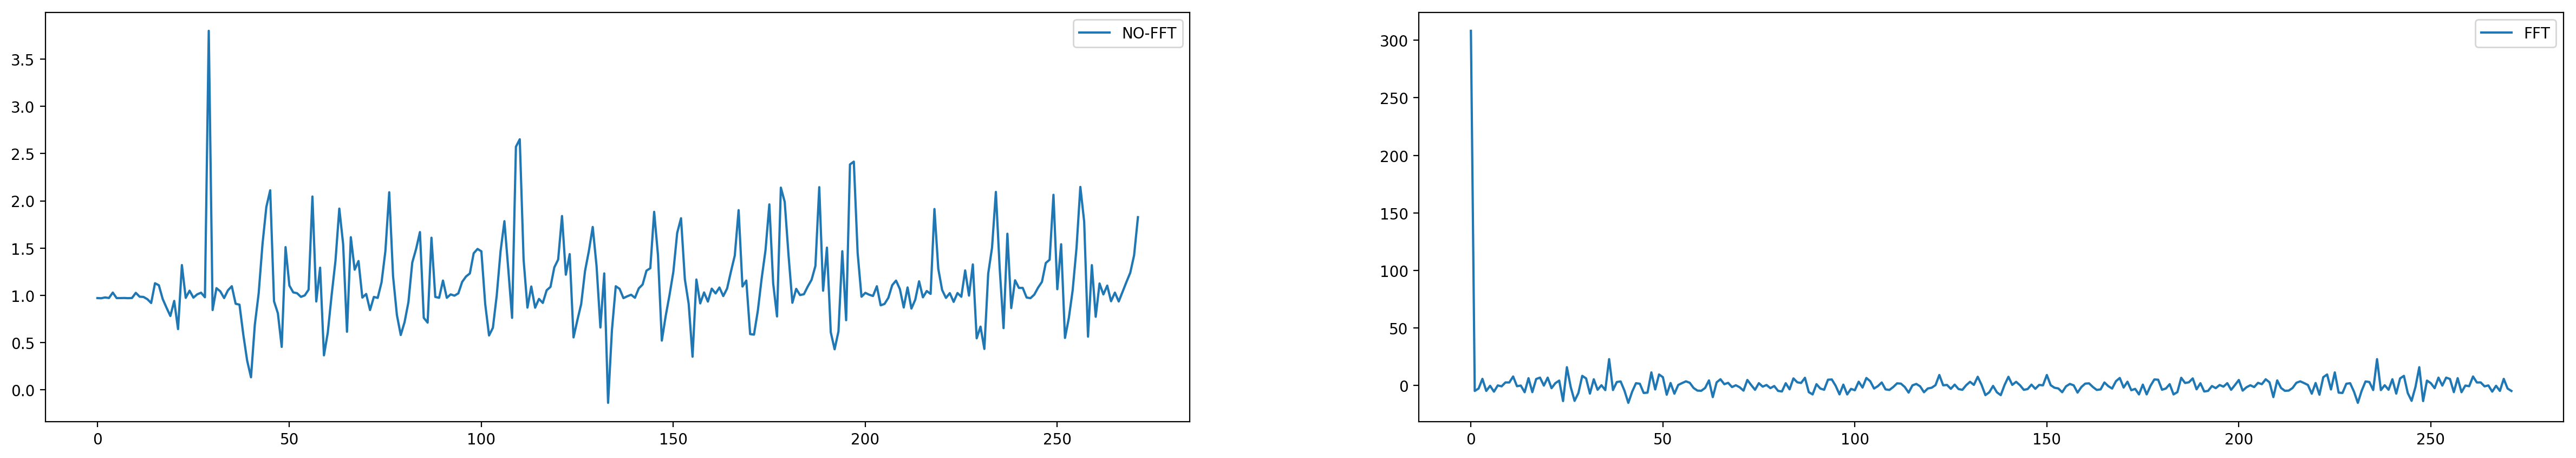

In [139]:
# Without Fast Fourier Transformation
subject = all_values[all_values['userID'].isin(['Subject 01'])]
subject_pos = subject[subject['position'].isin(['ankle'])]
subject_pos_label = subject_pos[subject_pos['experiment'].isin(['Walking_3'])]
subject_pos_label = subject_pos_label.sort_values(['Fts(ms)'])

accX = subject_pos_label['accX'].values
print(len(accX))
# FTT
from scipy.fftpack import fft, ifft
y = fft(accX)

# plot
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

fig, axs=plt.subplots(1,2)
fig.set_size_inches(30, 5, forward=True)
fig.set_dpi(200)
ax=axs.ravel()

ax[0].plot(pd.Series(accX))
ax[0].legend(['NO-FFT'])

ax[1].plot(pd.Series(y))
ax[1].legend(['FFT'])
fig.show()

C:\Users\barbosa\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  del sys.path[0]
C:\Users\barbosa\Anaconda3\lib\site-packages\numpy\core\numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


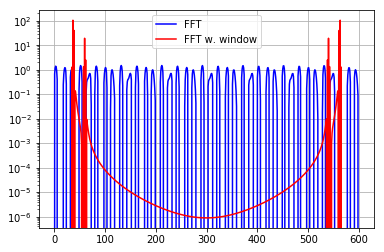

In [24]:
# FTT demo
# Windowing the signal with a dedicated window function helps mitigate spectral leakage. 
# The example below uses a Blackman window from scipy.signal and shows the effect of windowing 
# (the zero component of the FFT has been truncated for illustrative purposes).

from scipy.fftpack import fft
# Number of sample points
N = 600
# sample spacing
T = 1.0 / 800.0
x = np.linspace(0.0, N*T, N)
y = np.sin(50.0 * 2.0*np.pi*x) + 0.5*np.sin(80.0 * 2.0*np.pi*x)
yf = fft(y)
from scipy.signal import blackman
w = blackman(N)
ywf = fft(y*w)
xf = np.linspace(0.0, 1.0/(2.0*T), N/2)
import matplotlib.pyplot as plt
plt.semilogy(y, '-b')
plt.semilogy(ywf, '-r')
plt.legend(['FFT', 'FFT w. window'])
plt.grid()
plt.show()